In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np

In [16]:
raw_data = pd.read_csv('bear_shot_logs.csv')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GAME_ID                     128069 non-null  int64  
 1   MATCHUP                     128069 non-null  object 
 2   LOCATION                    128069 non-null  object 
 3   W                           128069 non-null  object 
 4   FINAL_MARGIN                128069 non-null  int64  
 5   SHOT_NUMBER                 128069 non-null  int64  
 6   PERIOD                      128069 non-null  int64  
 7   GAME_CLOCK                  128069 non-null  object 
 8   SHOT_CLOCK                  122502 non-null  float64
 9   DRIBBLES                    128069 non-null  int64  
 10  TOUCH_TIME                  128069 non-null  float64
 11  SHOT_DIST                   128069 non-null  float64
 12  PTS_TYPE                    128069 non-null  int64  
 13  SHOT_RESULT   

In [17]:
# Extract teams from matchup series, rename cols usefully
matchup_split = raw_data['MATCHUP'].str.split(" - ",n=1,expand=True)
matchup_split = matchup_split.rename(columns = {
    0:'DATE',
    1:'TEAMS'
})

# Extract which team was shooting/defending, rename cols usefully
matchup_teams = matchup_split['TEAMS'].str.split(" ",expand=True)
matchup_teams = matchup_teams.rename(columns = {
    0:'SHOOTING_TEAM',
    2:'DEFENDING_TEAM'
})

# Drop unecessary &/vs
matchup_teams = matchup_teams[['SHOOTING_TEAM','DEFENDING_TEAM']]

# Join both mini-dfs
matchup_data = matchup_split.join(matchup_teams)
matchup_data = matchup_data[['DATE', 'SHOOTING_TEAM', 'DEFENDING_TEAM']]

# merge that new mini df into original df
data_matchup_highlighted = raw_data.join(matchup_data)

# identify useful columns to keep
cols_keep = ['GAME_ID','PTS_TYPE', 'SHOT_RESULT', 'DEFENDING_TEAM', 'CLOSEST_DEFENDER',
             'CLOSE_DEF_DIST', 'PTS', 'FGM']

# Create overall dataset focused on relevant cols, and reordered cols usefully
clean_data = data_matchup_highlighted[cols_keep]

In [18]:
print(f"There are {len(clean_data['CLOSEST_DEFENDER'].unique())} identified defenders in the NBA.")

phi_data = clean_data[clean_data['DEFENDING_TEAM'] == 'PHI']
print(f"There are {len(phi_data['CLOSEST_DEFENDER'].unique())} identified defenders on the 76ers.")

There are 473 identified defenders in the NBA.
There are 23 identified defenders on the 76ers.


In [19]:
# We need to filter this such that only the defenders with 328 (4.0 opps/team game) instances of being the closest defender.
qualifying_opps = 82*4.0

# Get a count of how many times that player has been the closest defender (considered an opportunity)
qual_data = clean_data.value_counts('CLOSEST_DEFENDER').to_frame()
qual_data = qual_data.rename(columns = {0:'OPPORTUNITIES'})

# Join that data into the main df
opps_data = clean_data.join(qual_data,on='CLOSEST_DEFENDER')

# Filter for just 'qualified defenders', i.e., players with at least two opportunities per team game
qualified_data = opps_data[opps_data['OPPORTUNITIES'] >= qualifying_opps]
print(f"There are {len(qualified_data['CLOSEST_DEFENDER'].unique())} qualified defenders in the NBA.")

# Look at how many qualified defenders we have
phi_qual = qualified_data[qualified_data['DEFENDING_TEAM'] == 'PHI']
print(f"There are {len(phi_qual['CLOSEST_DEFENDER'].unique())} qualified defenders on the 76ers.")


There are 170 qualified defenders in the NBA.
There are 7 qualified defenders on the 76ers.


In [20]:
# Filter for just two-pointers
twos_data = qualified_data[qualified_data['PTS_TYPE'] == 2]
# Count how many times that defender had an opportunity, put into mini df
twos_counts = twos_data.value_counts(['CLOSEST_DEFENDER','GAME_ID']).to_frame()
twos_counts = twos_counts.rename(columns = {0:'2PT_DEF_OPP'})

# Filter for just three-pointers
tris_data = qualified_data[qualified_data['PTS_TYPE'] == 3]
# Count how many times that defender had an opportunity, put into mini df
tris_counts = tris_data.value_counts(['CLOSEST_DEFENDER','GAME_ID']).to_frame()
tris_counts = tris_counts.rename(columns = {0:'3PT_DEF_OPP'})

# Put two-pointer opportunity counts into main df
qual_pts_type_disagg = qualified_data.join(twos_counts,on=['CLOSEST_DEFENDER','GAME_ID'])
# Then put three-pointer opportunity counts into main df
qual_pts_type_disagg = qual_pts_type_disagg.join(tris_counts,on=['CLOSEST_DEFENDER','GAME_ID'])

# If they had no opportunites, that turn that NaN into a 0
qual_pts_type_disagg['2PT_DEF_OPP'] = qual_pts_type_disagg['2PT_DEF_OPP'].fillna(0)
qual_pts_type_disagg['3PT_DEF_OPP'] = qual_pts_type_disagg['3PT_DEF_OPP'].fillna(0)

In [21]:
# Figure out how many two pointers were made against the defender
twos_made = twos_data[twos_data['SHOT_RESULT'] == 'made'].value_counts(['CLOSEST_DEFENDER','GAME_ID']).to_frame()
twos_made = twos_made.rename(columns = {0:'2PT_MADE_AGAINST'})

# Figure out how many three pointers were made against the defender
tris_made = tris_data[tris_data['SHOT_RESULT'] == 'made'].value_counts(['CLOSEST_DEFENDER','GAME_ID']).to_frame()
tris_made = tris_made.rename(columns = {0:'3PT_MADE_AGAINST'})

# merge those back into the main df
quals_made = qual_pts_type_disagg.join(twos_made,on=['CLOSEST_DEFENDER','GAME_ID'])
quals_made = quals_made.join(tris_made,on=['CLOSEST_DEFENDER','GAME_ID'])

# If they had no opportunites, that turn that NaN into a 0
quals_made['2PT_MADE_AGAINST'] = quals_made['2PT_MADE_AGAINST'].fillna(0)
quals_made['3PT_MADE_AGAINST'] = quals_made['3PT_MADE_AGAINST'].fillna(0)

In [22]:
# Add columns that calculate success rates against
quals_made['2PT_MADE_RATE'] = 100*quals_made['2PT_MADE_AGAINST'] / quals_made['2PT_DEF_OPP']
quals_made['3PT_MADE_RATE'] = 100*quals_made['3PT_MADE_AGAINST'] / quals_made['3PT_DEF_OPP']

# Fill NAs w/ zeros
quals_made['2PT_MADE_RATE'] = quals_made['2PT_MADE_RATE'].fillna(0)
quals_made['3PT_MADE_RATE'] = quals_made['3PT_MADE_RATE'].fillna(0)

In [23]:
# Narrow down the columns again
keep_cols = ['GAME_ID', 'DEFENDING_TEAM', 'CLOSEST_DEFENDER', 'OPPORTUNITIES',
       '2PT_DEF_OPP', '3PT_DEF_OPP', '2PT_MADE_AGAINST', '3PT_MADE_AGAINST',
       '2PT_MADE_RATE', '3PT_MADE_RATE']
qual_focus = quals_made[keep_cols]

# Drop dupes will give us one row, per player, per game
# That row summarizes all shot data for that player, for that game
trim_qual = qual_focus.drop_duplicates(subset=['CLOSEST_DEFENDER','GAME_ID'])
trim_qual_phi = trim_qual[trim_qual['DEFENDING_TEAM'] == 'PHI']

In [24]:
## For all NBA, make dictionary where the key is the qualified defender,
## and the list is the list of all success rates against them in each game

# for 2 pointers
dict_2pt = {}
for name in trim_qual['CLOSEST_DEFENDER'].unique():
    dict_2pt[name] = trim_qual[trim_qual['CLOSEST_DEFENDER'] == name]['2PT_MADE_RATE'].tolist()

# and 3 pointers
dict_3pt = {}
for name in trim_qual['CLOSEST_DEFENDER'].unique():
    dict_3pt[name] = trim_qual[trim_qual['CLOSEST_DEFENDER'] == name]['3PT_MADE_RATE'].tolist()

In [25]:
### do the same as above for just philly
## for two pointers
# set initial dictionary
dict_2pt_phi = {}

# for every name in the list of qualified defenders, add their name as a new key in dictionary,
# and make the associated value a list of success rates
for name in trim_qual_phi['CLOSEST_DEFENDER'].unique():
    dict_2pt_phi[name] = trim_qual_phi[trim_qual_phi['CLOSEST_DEFENDER'] == name]['2PT_MADE_RATE'].tolist()

# throw in the best defender that year, for comparison
trim_qual_best = trim_qual[trim_qual['CLOSEST_DEFENDER'] == 'Leonard, Kawhi']
best_defender_2pts = trim_qual_best['2PT_MADE_RATE'].tolist()
dict_2pt_phi['Leonard, Kawhi'] = best_defender_2pts



## for 3 pointers
dict_3pt_phi = {}

# for every name in the list of qualified defenders, add their name as a new key in dictionary,
# and make the associated value a list of success rates
for name in trim_qual_phi['CLOSEST_DEFENDER'].unique():
    dict_3pt_phi[name] = trim_qual_phi[trim_qual_phi['CLOSEST_DEFENDER'] == name]['3PT_MADE_RATE'].tolist()

# throw in the best defender that year, for comparison
trim_qual_best = trim_qual[trim_qual['CLOSEST_DEFENDER'] == 'Leonard, Kawhi']
best_defender_3pts = trim_qual_best['3PT_MADE_RATE'].tolist()
dict_3pt_phi['Leonard, Kawhi'] = best_defender_3pts

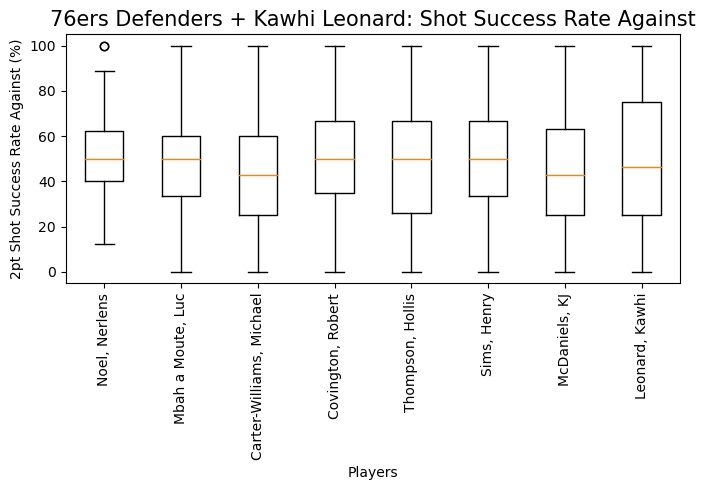

In [26]:
# dataset done, just need to create a list for each guy now, and turn into a boxplot
plt.rcParams["figure.figsize"] = [7,5]
plt.rcParams["figure.autolayout"] = True

fig2, ax2 = plt.subplots()

ax2.boxplot(dict_2pt_phi.values())
ax2.set_xticklabels(dict_2pt_phi.keys(), rotation=90)

ax2.set_title('76ers Defenders + Kawhi Leonard: Shot Success Rate Against', fontsize = 15)
ax2.set_xlabel('Players')
ax2.set_ylabel('2pt Shot Success Rate Against (%)')

plt.savefig('bear_twopt_defense.png')
plt.show()

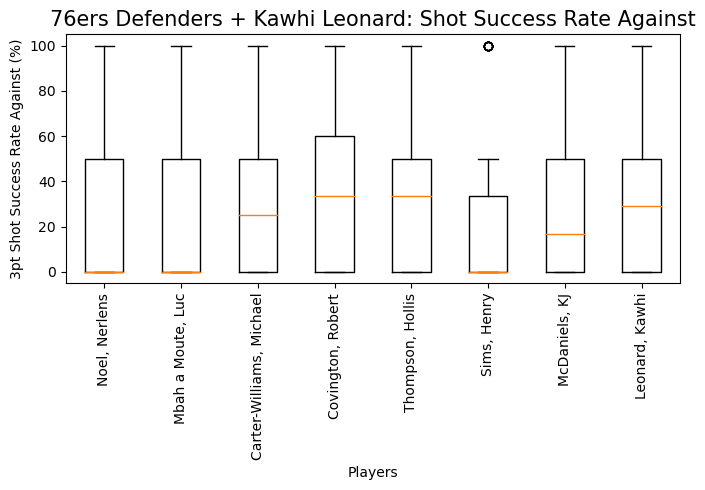

In [27]:
# dataset done, just need to create a list for each guy now, and turn into a boxplot
plt.rcParams["figure.figsize"] = [7,5]
plt.rcParams["figure.autolayout"] = True

fig3, ax3 = plt.subplots()

ax3.boxplot(dict_3pt_phi.values())
ax3.set_xticklabels(dict_3pt_phi.keys(), rotation=90)

ax3.set_title('76ers Defenders + Kawhi Leonard: Shot Success Rate Against', fontsize = 15)
ax3.set_xlabel('Players')
ax3.set_ylabel('3pt Shot Success Rate Against (%)')

plt.savefig('bear_tript_defense.png')
plt.show()